<a href="https://colab.research.google.com/github/Osterne/codes_book/blob/main/04_inferencia_03_est_pontual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

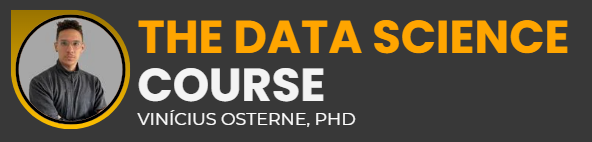

---
# Inferência Estatística - Estimação Pontual
---

## 🎯 Roteiro

- Métodos analíticos clássicos
  - Método dos Momentos (MM)
  - Método da Máxima Verossimilhança (MLE)

- Métodos numéricos de estimação
  - Newton-Raphson
  - Fisher Scoring
  - Algoritmo EM (Expectation-Maximization)

- Métodos de avaliação de estimadores
  - Viés e variância
  - Erro quadrático médio (EQM)

---
## Tópicos extras
- Existem casos alternativos ao MLE (vistos dentro do contexto de **Modelos de Regressão**):
  - **Verossimilhança Perfilada:** quando há parâmetros de interesse e de perturbação
  - **Verossimilhança Restrita (REML):** usada para variância em modelos mistos
  - **Verossimilhança Penalizada:** combinação entre verossimilhança e regularização
  - **Quase-Verossimilhança:** aplicada quando a distribuição completa não é conhecida, como em GLMs com superdispersão

- Outros métodos de estimação (Inferência II):
  - **Estimação/Inferência Bayesiana:** Inferência que combina informação prévia (distribuição a priori) com os dados observados para obter uma distribuição a posteriori dos parâmetros
  - **Estimação/Inferência Robusta:** Inferência que busca estimadores insensíveis a outliers ou pequenas violações de suposições do modelo
  - **Estimação/Inferência Não Paramétrica:** Inferência baseada em estatísticas que não assumem uma forma específica para a distribuição dos dados
  - **Estimação/Inferência Semi Paramétrica:** Inferência que assume parcialmente uma estrutura paramétrica e deixa outra parte livre
  - **Estimação/Inferência Computacional (ou via Reamostragem):** Usa simulações ou reamostragem para inferir parâmetros.


---
# Métodos analíticos clássicos

## 📘 Método dos Momentos (MM)

O **Método dos Momentos** é uma técnica clássica de estimação de parâmetros que se baseia em uma ideia intuitiva:

> *Se a amostra é representativa da população, então os momentos calculados na amostra devem ser próximos dos momentos teóricos da distribuição populacional.*

---

### 🔹 Conceito básico

Os **momentos teóricos** de uma distribuição dependem dos parâmetros que queremos estimar.  
Para uma variável aleatória contínua com função densidade $ f(x; \theta) $, o momento populacional de ordem $ k $ é definido como:

$$
m_k(\theta) = \mathbb{E}[X^k] = \int_{-\infty}^{\infty} x^k f(x; \theta) \, dx
$$

Por outro lado, os **momentos amostrais** são obtidos a partir dos dados observados:

$$
\hat{m}_k = \frac{1}{n} \sum_{i=1}^n X_i^k
$$


### 🔹 Ideia do método

O **Método dos Momentos** propõe **igualar os momentos amostrais aos teóricos**:

- Se temos **1 parâmetro**, igualamos o primeiro momento:

$$
\hat{m}_1 = m_1(\theta)
$$

- Se temos **2 parâmetros**, igualamos os dois primeiros momentos:

$$
\begin{cases}
\hat{m}_1 = m_1(\theta_1, \theta_2) \\
\hat{m}_2 = m_2(\theta_1, \theta_2)
\end{cases}
$$

E assim por diante, para mais parâmetros.  
Resolvendo esse sistema de equações, obtemos os **estimadores dos parâmetros**.

### 🔹 Vantagens e limitações

✅ **Vantagens:**
- Simples e direto, muitas vezes com solução fechada.
- Útil quando a função de verossimilhança é complicada ou desconhecida.
- Não exige a distribuição completa — apenas os momentos.

⚠️ **Limitações:**
- Pode ser **menos eficiente** do que o MLE (estimador de máxima verossimilhança).
- É **sensível a outliers**, especialmente se usar momentos de ordem superior.
- Pode falhar se os momentos teóricos não existirem ou forem pouco informativos.

### 🔹 Exemplo: Distribuição Gamma

Considere uma variável $X \sim \text{Gamma}(\alpha, \beta)$.  
Seus momentos teóricos são:

- Média: $\mu = \alpha \beta$
- Variância: $\sigma^2 = \alpha \beta^2$

A partir da amostra, calculamos a média $\bar{X}$ e a variância amostral $S^2$, e igualamos:

$$
\bar{X} = \alpha \beta, \quad S^2 = \alpha \beta^2
$$

Resolvendo esse sistema:

$$
\beta = \frac{S^2}{\bar{X}}, \quad \alpha = \frac{\bar{X}}{\beta}
$$

Abaixo, aplicamos isso a uma amostra simulada da distribuição Gamma:

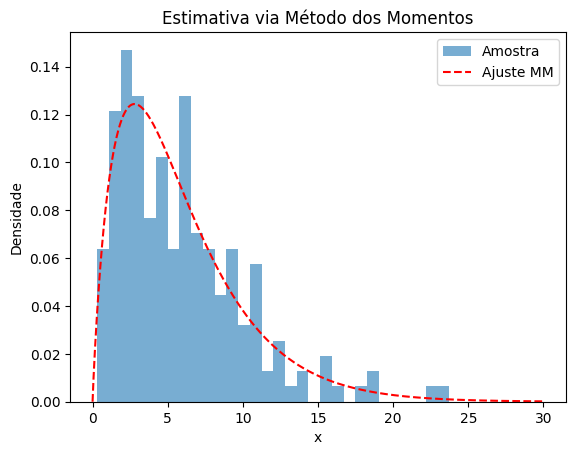

In [9]:
# Exemplo: distribuição Gamma(α, β), estimando parâmetros por MM
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt

# Simulação da população e extração de uma amostra
np.random.seed(42)
pop = gamma.rvs(a=2, scale=3, size=100000)  # α=2, β=3
sample = np.random.choice(pop, size=200)

# Cálculo dos momentos amostrais
mean_x = np.mean(sample)
var_x = np.var(sample, ddof=1)

# Estimação via MM
beta_mm = var_x / mean_x
alpha_mm = mean_x / beta_mm

# Visualização do ajuste
plt.hist(sample, bins=30, density=True, alpha=0.6, label="Amostra")
x_vals = np.linspace(0, 30, 1000)
plt.plot(x_vals, gamma.pdf(x_vals, a=alpha_mm, scale=beta_mm), 'r--', label="Ajuste MM")
plt.title("Estimativa via Método dos Momentos")
plt.xlabel("x")
plt.ylabel("Densidade")
plt.legend()
plt.show()

## 📘 Método da Máxima Verossimilhança (MLE)

A **Máxima Verossimilhança** é um dos métodos mais poderosos e amplamente utilizados para estimação pontual.  
Sua ideia central é simples e intuitiva:

> *Escolher os parâmetros que tornam os dados observados mais prováveis.*


### 🔹 Definição

Seja $X_1, X_2, \dots, X_n$ uma amostra aleatória de uma população com função densidade (ou massa) $f(x;\theta)$, onde $\theta$ representa o vetor de parâmetros desconhecidos.

A **função de verossimilhança** é definida como:

$$
L(\theta) = \prod_{i=1}^n f(x_i; \theta)
$$

Ela representa a "probabilidade" de observar os dados $x_1, \dots, x_n$, assumindo que $\theta$ seja o verdadeiro valor dos parâmetros.


### 🔹 Log-Verossimilhança

Para facilitar o cálculo (principalmente derivadas), usamos a **log-verossimilhança**, que transforma o produto em soma:

$$
\ell(\theta) = \log L(\theta) = \sum_{i=1}^n \log f(x_i; \theta)
$$

O **estimador de máxima verossimilhança (MLE)** é o valor de $\theta$ que **maximiza** essa função:

$$
\hat{\theta}_{\text{MLE}} = \arg \max_{\theta} \ell(\theta)
$$


### 🔹 Propriedades desejáveis do MLE

- **Consistência**: $\hat{\theta}_{\text{MLE}} \to \theta$ quando $n \to \infty$
- **Invariância**: se $\hat{\theta}$ é MLE de $\theta$, então $g(\hat{\theta})$ é MLE de $g(\theta)$
- **Assintoticamente eficiente**: atinge o limite de Cramér-Rao para grandes amostras
- **Distribuição assintótica**: $\hat{\theta}_{\text{MLE}} \overset{approx}{\sim} N(\theta, I^{-1}(\theta))$


### 🔹 Comparação com outros métodos

O MLE costuma fornecer estimadores **mais precisos** que o Método dos Momentos, especialmente em grandes amostras.  
Entretanto, ele exige:

- Conhecimento completo da forma da distribuição
- Derivação da função de verossimilhança
- Otimização (às vezes numérica) — especialmente em modelos complexos

## 📘 Estimação por Máxima Verossimilhança – Exemplo Detalhado com a Distribuição Gamma

Vamos aplicar o **Método da Máxima Verossimilhança (MLE)** para estimar os parâmetros da distribuição Gamma: $X \sim \text{Gamma}(\alpha, \beta)$  
(com **parametrização por forma $\alpha$ e escala $\beta$**).


### Passo 1. Função de verossimilhança

A função densidade da distribuição Gamma é dada por:

$$
f(x; \alpha, \beta) = \frac{1}{\Gamma(\alpha)\beta^\alpha} x^{\alpha - 1} e^{-x/\beta}, \quad x > 0
$$

A função de verossimilhança para uma amostra $x_1, x_2, \dots, x_n$ é:

$$
L(\alpha, \beta) = \prod_{i=1}^n \frac{1}{\Gamma(\alpha)\beta^\alpha} x_i^{\alpha - 1} e^{-x_i/\beta}
$$


### Passo 2. Log-verossimilhança

Tomando logaritmo:

$$
\ell(\alpha, \beta) = \sum_{i=1}^n \left[ -\log \Gamma(\alpha) - \alpha \log \beta + (\alpha - 1)\log x_i - \frac{x_i}{\beta} \right]
$$

Agrupando termos:

$$
\ell(\alpha, \beta) = -n \log \Gamma(\alpha) - n\alpha \log \beta + (\alpha - 1)\sum_{i=1}^n \log x_i - \frac{1}{\beta} \sum_{i=1}^n x_i
$$


### Passo 3. Derivadas parciais (Equações de score)

#### Derivada em relação a $\beta$:

$$
\frac{\partial \ell}{\partial \beta} = -\frac{n\alpha}{\beta} + \frac{1}{\beta^2} \sum x_i
$$

Igualando a zero:

$$
-\frac{n\alpha}{\beta} + \frac{1}{\beta^2} \sum x_i = 0
$$

Multiplicando ambos os lados por $\beta^2$:

$$
-n\alpha \beta + \sum x_i = 0 \quad \Rightarrow \quad \hat{\beta} = \frac{1}{n\alpha} \sum x_i = \frac{\bar{x}}{\alpha}
$$

---

#### Derivada em relação a $\alpha$ (não tem solução fechada):

$$
\frac{\partial \ell}{\partial \alpha} = -n \psi(\alpha) - n \log \beta + \sum \log x_i = 0
$$

Onde $\psi(\alpha)$ é a **função digama** (derivada do log da função gama).

Reescrevendo:

$$
\psi(\alpha) - \log \left( \frac{1}{n} \sum x_i \right) + \frac{1}{n} \sum \log x_i = 0
$$

Ou seja, **é preciso resolver numericamente** para encontrar $\hat{\alpha}$, e depois substituir em $\hat{\beta} = \bar{x}/\hat{\alpha}$.


### Passo 4. Implementação prática com cálculo aproximado

Vamos agora aplicar esse procedimento em código:

Estimativa analítica por MLE:
α (forma) = 2.4807
β (escala) = 2.4040


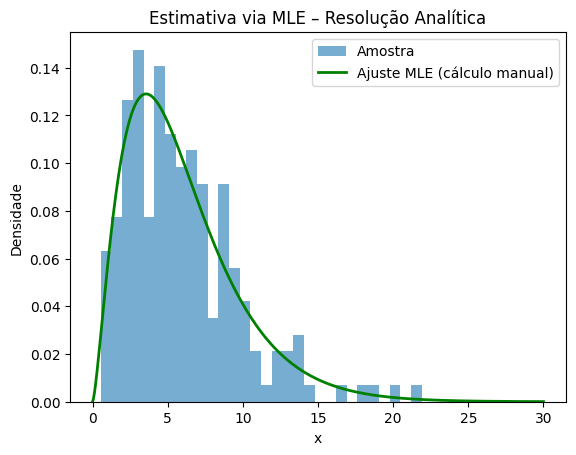

In [10]:
import numpy as np
from scipy.special import psi  # função digama
from scipy.optimize import root_scalar
from scipy.stats import gamma
import matplotlib.pyplot as plt

# Simulação
np.random.seed(42)
x = gamma.rvs(a=2, scale=3, size=200)  # α = 2, β = 3
n = len(x)
x_bar = np.mean(x)
log_x_bar = np.mean(np.log(x))

# Função da equação de score para α
def score_alpha(alpha):
    return np.log(alpha) - psi(alpha) - np.log(x_bar) + log_x_bar

# Resolver numericamente para α (usando método da bisseção)
sol = root_scalar(score_alpha, bracket=[0.1, 10], method='bisect')
alpha_hat = sol.root

# Estimar β usando a equação fechada
beta_hat = x_bar / alpha_hat

print(f"Estimativa analítica por MLE:")
print(f"α (forma) = {alpha_hat:.4f}")
print(f"β (escala) = {beta_hat:.4f}")

# Visualização
plt.hist(x, bins=30, density=True, alpha=0.6, label="Amostra")
xx = np.linspace(0, 30, 500)
plt.plot(xx, gamma.pdf(xx, a=alpha_hat, scale=beta_hat), 'g-', lw=2, label="Ajuste MLE (cálculo manual)")
plt.title("Estimativa via MLE – Resolução Analítica")
plt.xlabel("x")
plt.ylabel("Densidade")
plt.legend()
plt.show()

## 📊 Comparação: Método dos Momentos vs Máxima Verossimilhança (MLE) para a Distribuição Gamma

Quando queremos estimar os parâmetros da distribuição $X \sim \text{Gamma}(\alpha, \beta)$, duas abordagens clássicas são:

- O **Método dos Momentos (MM)**: iguala momentos teóricos aos momentos amostrais.
- O **Método da Máxima Verossimilhança (MLE)**: maximiza a probabilidade da amostra observada.

### Estimadores por MM

A distribuição Gamma tem:

- $\mathbb{E}[X] = \alpha \beta$
- $\mathbb{V}[X] = \alpha \beta^2$

Igualando à média e variância amostral, obtemos os estimadores do MM:

$$
\hat{\beta}_{\text{MM}} = \frac{s^2}{\bar{x}}, \quad \hat{\alpha}_{\text{MM}} = \frac{\bar{x}}{\hat{\beta}_{\text{MM}}} = \frac{\bar{x}^2}{s^2}
$$


### Estimadores por MLE

A função de log-verossimilhança leva a duas equações de score:

- Para $\beta$:
  
$$
\hat{\beta}_{\text{MLE}} = \frac{\bar{x}}{\hat{\alpha}_{\text{MLE}}}
$$

- Para $\alpha$ (equação implícita):

$$
\log(\hat{\alpha}) - \psi(\hat{\alpha}) = \log(\bar{x}) - \bar{\log x}
$$

Essa equação deve ser resolvida numericamente.


### ⚠️ Conclusão: os estimadores **não são iguais**

- O MM depende da **média e variância amostral**
- O MLE depende da **média aritmética e média logarítmica**
- Ambos produzem estimativas diferentes, principalmente em pequenas amostras.

---

### ✅ Tabela Comparativa

| Método                  | Estimativa de $ \alpha $                         | Estimativa de $ \beta $                        | Observações                                 |
|------------------------|--------------------------------------------------|------------------------------------------------|---------------------------------------------|
| **Momentos (MM)**      | $ \frac{\bar{x}^2}{s^2} $                        | $ \frac{s^2}{\bar{x}} $                        | Simples, mas menos eficiente                |
| **Verossimilhança (MLE)** | Numérica: $ \log(\alpha) - \psi(\alpha) = \log(\bar{x}) - \bar{\log x} $ | $ \frac{\bar{x}}{\hat{\alpha}} $              | Mais precisa, mas requer otimização         |

---

## 📈 Comparação Gráfica dos Ajustes

Abaixo comparamos as curvas ajustadas pelos dois métodos para a mesma amostra da distribuição Gamma.


Estimativas MM:    alpha = 2.4311, beta = 2.4531
Estimativas MLE:   alpha = 2.4807, beta = 2.4040


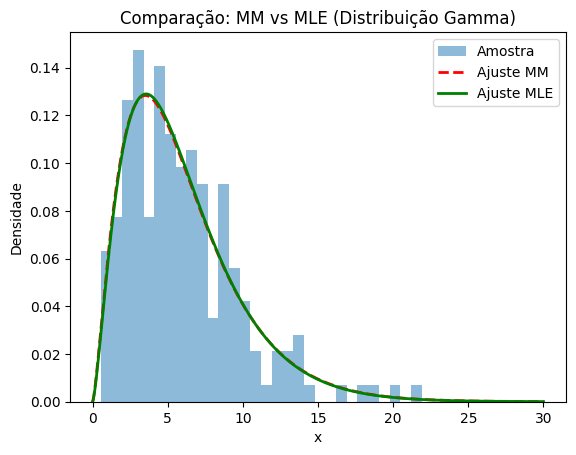

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.special import psi
from scipy.optimize import root_scalar

# Simulação da amostra
np.random.seed(42)
sample = gamma.rvs(a=2, scale=3, size=200)

# Momentos amostrais
x_bar = np.mean(sample)
s2 = np.var(sample, ddof=1)
log_x_bar = np.mean(np.log(sample))

# Estimativas por Método dos Momentos (MM)
alpha_mm = x_bar**2 / s2
beta_mm = s2 / x_bar

# Estimativas por Máxima Verossimilhança (MLE)
def score_alpha(alpha):
    return np.log(alpha) - psi(alpha) - np.log(x_bar) + log_x_bar

sol = root_scalar(score_alpha, bracket=[0.1, 10], method='bisect')
alpha_mle = sol.root
beta_mle = x_bar / alpha_mle

# Imprimir resultados
print(f"Estimativas MM:    alpha = {alpha_mm:.4f}, beta = {beta_mm:.4f}")
print(f"Estimativas MLE:   alpha = {alpha_mle:.4f}, beta = {beta_mle:.4f}")

# Visualização
x_vals = np.linspace(0, 30, 1000)
plt.hist(sample, bins=30, density=True, alpha=0.5, label="Amostra")
plt.plot(x_vals, gamma.pdf(x_vals, a=alpha_mm, scale=beta_mm), 'r--', lw=2, label="Ajuste MM")
plt.plot(x_vals, gamma.pdf(x_vals, a=alpha_mle, scale=beta_mle), 'g-', lw=2, label="Ajuste MLE")
plt.title("Comparação: MM vs MLE (Distribuição Gamma)")
plt.xlabel("x")
plt.ylabel("Densidade")
plt.legend()
plt.show()


---
# Métodos Numéricos de Estimação

Quando o MLE não pode ser obtido analiticamente, usamos métodos numéricos como:

- Newton-Raphson
- Fisher Scoring
- Algoritmo EM (Expectation-Maximization)

Vamos ver um exemplo simples com o algoritmo EM.

## Newton-Raphson

O método de **Newton-Raphson** é um algoritmo iterativo usado para encontrar raízes de uma função — neste caso, o ponto onde a derivada da log-verossimilhança (score) é zero.

A atualização é dada por:

$$
\theta^{(t+1)} = \theta^{(t)} - \frac{\ell'(\theta^{(t)})}{\ell''(\theta^{(t)})}
$$

Onde:
- $ \ell'(\theta) $ é a derivada da log-verossimilhança (score)
- $ \ell''(\theta) $ é a segunda derivada (hessiana)

Esse método é eficiente, mas exige que a hessiana seja conhecida e não singular.

## Newton-Raphson (Exemplo/Aplicação)

### 📘 Objetivo:
Estimar a média $ \mu $ de uma distribuição Normal com variância conhecida, utilizando o método de Newton-Raphson para maximizar a log-verossimilhança.

### 💡 Ideia:
Como a função de log-verossimilhança tem derivadas conhecidas, podemos aplicar o método iterativamente:

$$
\mu^{(t+1)} = \mu^{(t)} - \frac{\ell'(\mu^{(t)})}{\ell''(\mu^{(t)})}
$$

Neste exemplo, os dados são simulados de uma $ N(5, 2^2) $ e partimos de um chute inicial $ \mu = 0 $.

In [12]:
import numpy as np

# Simula dados
np.random.seed(42)
mu_true = 5
sigma2 = 4  # variância conhecida
x = np.random.normal(mu_true, np.sqrt(sigma2), size=100)
n = len(x)

# Score e hessiana da log-verossimilhança
def score(mu):
    return np.sum(x - mu) / sigma2

def hessian(mu):
    return -n / sigma2

# Newton-Raphson
mu = 0  # chute inicial
tol = 1e-6
max_iter = 10

for i in range(max_iter):
    mu_new = mu - score(mu) / hessian(mu)
    if abs(mu_new - mu) < tol:
        break
    mu = mu_new

print(f"Estimativa de mu (Newton-Raphson): {mu:.4f}")


Estimativa de mu (Newton-Raphson): 4.7923


## Fisher Scoring

O **Fisher Scoring** é uma variação do Newton-Raphson. Em vez de usar a hessiana observada, usa a **informação de Fisher**, que é a esperança da hessiana negativa.

A fórmula de atualização se torna:

$$
\theta^{(t+1)} = \theta^{(t)} + \left[I(\theta^{(t)})\right]^{-1} \cdot U(\theta^{(t)})
$$

Onde:
- $ U(\theta) = \ell'(\theta) $ é o vetor score
- $ I(\theta) = -\mathbb{E}[\ell''(\theta)] $ é a matriz de informação de Fisher

Esse método é mais estável quando a variabilidade da hessiana é alta.

## Fisher Scoring (Exemplo/Aplicação)

### 📘 Objetivo:
Resolver o mesmo problema do exemplo anterior (estimação da média), mas utilizando a **informação de Fisher** em vez da hessiana observada.

### 💡 Ideia:
O método de Fisher Scoring é uma versão mais estável do Newton-Raphson, substituindo a hessiana pela expectativa da hessiana negativa:

$$
\mu^{(t+1)} = \mu^{(t)} + \frac{U(\mu^{(t)})}{I(\mu^{(t)})}
$$

Neste caso, a informação de Fisher é constante e igual a $ n / \sigma^2 $, o que torna as iterações simples e rápidas.


In [13]:
# Score e informação de Fisher
def score(mu):
    return np.sum(x - mu) / sigma2

def fisher_info(mu):
    return n / sigma2

# Fisher Scoring
mu = 0  # chute inicial
for i in range(max_iter):
    mu_new = mu + score(mu) / fisher_info(mu)
    if abs(mu_new - mu) < tol:
        break
    mu = mu_new

print(f"Estimativa de mu (Fisher Scoring): {mu:.4f}")


Estimativa de mu (Fisher Scoring): 4.7923


## Algoritmo EM (Expectation-Maximization)

O **Algoritmo EM** é útil quando há **dados incompletos, ocultos ou variáveis latentes**. Ele busca maximizar a **verossimilhança marginal** dos dados observados de forma iterativa.

É composto por dois passos:

### E-step (Expectação):
Calcula a **esperança** da log-verossimilhança completa, condicionada aos dados observados e aos parâmetros atuais.

$$
Q(\theta \mid \theta^{(t)}) = \mathbb{E}[\log L(\theta; X, Z) \mid X, \theta^{(t)}]
$$

### M-step (Maximização):
Maximiza essa esperança para obter os novos parâmetros:

$$
\theta^{(t+1)} = \arg \max_\theta Q(\theta \mid \theta^{(t)})
$$

O EM é muito usado em:
- Misturas de distribuições (ex: mistura de Normais)
- Dados censurados
- Modelos com efeitos aleatórios

Apesar de convergir lentamente, é robusto e simples de implementar.

## Algoritmo EM (Exemplo/Aplicaçao)

### 📘 Objetivo:
Estimar os parâmetros de uma **mistura de duas distribuições Normais** com variâncias conhecidas.

Os dados são simulados a partir da mistura:

$$
X \sim \pi \cdot N(\mu_1, \sigma^2) + (1 - \pi) \cdot N(\mu_2, \sigma^2)
$$

### 💡 Ideia:
Como a variável latente $ Z $ (que indica de qual componente cada observação veio) não é observada, usamos o algoritmo EM:

- **E-step:** Calcular a responsabilidade (probabilidade de cada observação pertencer à componente 1)
- **M-step:** Atualizar $ \pi $, $ \mu_1 $ e $ \mu_2 $ com base nas responsabilidades

Este processo é repetido até convergência. Vamos avaliar a implementação a seguir!


Estimativas finais:
pi = 0.696, mu1 = 1.963, mu2 = 6.912


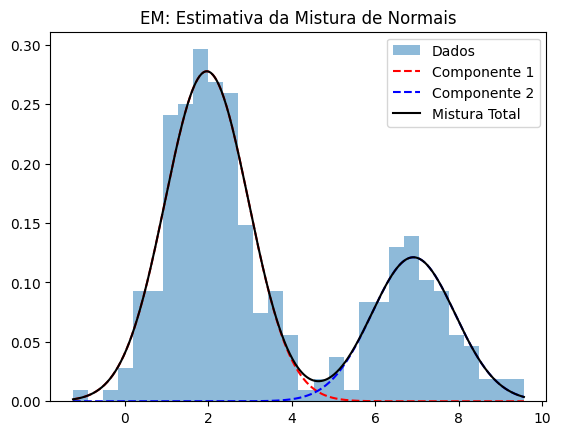

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Gerar dados de uma mistura de duas normais
np.random.seed(42)
n = 300
z = np.random.binomial(1, 0.7, size=n)  # classe latente
x = z * np.random.normal(2, 1, size=n) + (1 - z) * np.random.normal(7, 1, size=n)

# Inicializar parâmetros
pi = 0.5
mu1, mu2 = 1.0, 6.0
sigma = 1.0

# Algoritmo EM
for i in range(100):
    # E-step: responsabilidades (probabilidades de pertencer à componente 1)
    r1 = pi * norm.pdf(x, mu1, sigma)
    r2 = (1 - pi) * norm.pdf(x, mu2, sigma)
    gamma = r1 / (r1 + r2)  # responsabilidade de cada ponto

    # M-step: atualizar parâmetros
    pi = np.mean(gamma)
    mu1 = np.sum(gamma * x) / np.sum(gamma)
    mu2 = np.sum((1 - gamma) * x) / np.sum(1 - gamma)

print(f"Estimativas finais:")
print(f"pi = {pi:.3f}, mu1 = {mu1:.3f}, mu2 = {mu2:.3f}")

# Visualização
plt.hist(x, bins=30, density=True, alpha=0.5, label="Dados")
xx = np.linspace(min(x), max(x), 500)
plt.plot(xx, pi * norm.pdf(xx, mu1, sigma), 'r--', label="Componente 1")
plt.plot(xx, (1 - pi) * norm.pdf(xx, mu2, sigma), 'b--', label="Componente 2")
plt.plot(xx,
         pi * norm.pdf(xx, mu1, sigma) + (1 - pi) * norm.pdf(xx, mu2, sigma),
         'k-', label="Mistura Total")
plt.title("EM: Estimativa da Mistura de Normais")
plt.legend()
plt.show()